<a href="https://colab.research.google.com/github/sagitiminsky/Final-Project-in-Advanced-Lectures-in-Learning-Theory/blob/part1/part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [21]:
import torchvision.datasets as datasets
import torch
import torchvision.transforms
import copy
!pip3 install wandb
!wandb login
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

wandb: Currently logged in as: sagit (use `wandb login --relogin` to force relogin)


# Sources


1.   GD - https://www.linkedin.com/pulse/pytorch-gradient-descent-stochastic-mini-batch-code-sobh-phd/
2.  Constrained GD - https://botorch.org/tutorials/optimize_stochastic



# Connect to Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
root="/content/drive/MyDrive/university/Masters/datasets"

# MNIST Dataset Preprocessing


*   According to the assignment, we should construct one big data set (which you will later divide to train-test by our selves.
*   We will preform the following transformations: Flip the image horizontally and then rotate it 90 degrees anti-clockwise. Without if the images are not alligend correctly which might suboptimal results in run-time (We assume that the images proviveded in run time are alligned correctly)




In [24]:
transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img)
                ])

mnist_trainset = datasets.EMNIST(root=root, train=True, split="mnist",download=True, transform=transform)
mnist_testset = datasets.EMNIST(root=root, train=False, split="mnist",download=True, transform=transform)

mnist_dataset=mnist_trainset + mnist_testset

In [25]:
def visualize_a_few_samples(dataset,n):
  for i in range(n):
    train_image_sample, train_target_sample = dataset[i]
    # display(train_image_sample)
    print(f'GT: {train_target_sample}')
    # print(f'size: {train_image_sample.size}')

visualize_a_few_samples(mnist_dataset,5)

GT: 4
GT: 1
GT: 4
GT: 1
GT: 6


# Preprocessing and creting 3 different classification problems




*   As before we fliped and rotated the image
*   The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset. It is important to do that because slow convergence might occur. 
Is illustrated left, the steepest gradient is searched which is somewhat in the correction direction but also possesses quite a large oscillation part. A relatively large learning rate is required for the surface are feature sicne its range is large. However this large learning rate is too large for the optimizer which overshoots at each step - this results in oscillation and hence slow convergence.
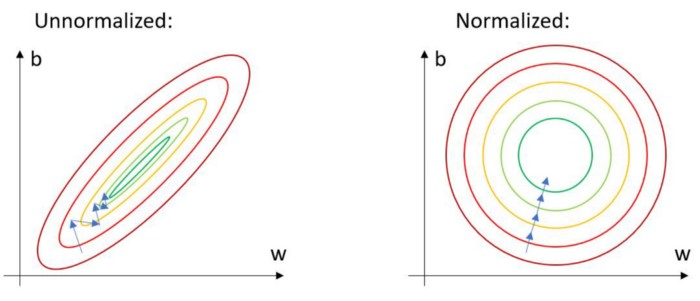




In [26]:
from torchvision.transforms import transforms
transform=torchvision.transforms.Compose([
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307), (0.3081))
                ])

In [27]:
#we assign the label 0 to all examples labeled [0,1,2,3,4] and the label 1 to all examples labeled [5,6,7,8,9]

def zero_to_four_vs_five_to_nine(number):
  if number>=0 and number<=4:
    res=torch.tensor([0]).to(torch.float32)
  elif number>=5 and number<=9:
     res=torch.tensor([1]).to(torch.float32)
  else:
    raise Exception(f"{number} is not a valid target in the dataset")

  return res

mnist_trainset_zero_to_four_vs_five_to_nine = datasets.EMNIST(root=root, train=True, split="mnist",download=True, transform=transform, target_transform=zero_to_four_vs_five_to_nine)
mnist_testset_zero_to_four_vs_five_to_nine = datasets.EMNIST(root=root, train=False, split="mnist",download=True, transform=transform, target_transform=zero_to_four_vs_five_to_nine)

mnist_dataset_zero_to_four_vs_five_to_nine = mnist_trainset_zero_to_four_vs_five_to_nine + mnist_testset_zero_to_four_vs_five_to_nine

visualize_a_few_samples(mnist_testset_zero_to_four_vs_five_to_nine, 5)

GT: tensor([0.])
GT: tensor([1.])
GT: tensor([1.])
GT: tensor([1.])
GT: tensor([1.])


In [28]:
#we assign the lable 1 to even numbers, and the label 0 to odd numbers
def even_vs_odd(number):
  if number>=0 and number<=9:
    return torch.tensor([number%2]).to(torch.float32)
  else:
    raise Exception(f"{number} is not a valid target in the dataset")


mnist_trainset_even_vs_odd = datasets.EMNIST(root=root, train=True, split="mnist",download=True, transform=transform, target_transform=even_vs_odd)
mnist_testset_even_vs_odd = datasets.EMNIST(root=root, train=False, split="mnist",download=True, transform=transform, target_transform=even_vs_odd)

mnist_dataset_even_vs_odd = mnist_trainset_even_vs_odd + mnist_testset_even_vs_odd

#visualize_a_few_samples(mnist_dataset_even_vs_odd, 5)

In [29]:
#we assign the lable 1 to primary numbers, and the label 0 to non primary numbers
def prime_vs_not_prime(number):
  is_prime=[1,2,3,5,7]
  if number>=0 and number<=9:
    if number in is_prime:
      return torch.tensor([1]).to(torch.float32)
    else:
      return torch.tensor([0]).to(torch.float32)
  else:
    raise Exception(f"{number} is not a valid target in the dataset")


mnist_trainset_prime_vs_not_prime = datasets.EMNIST(root=root, train=True, split="mnist",download=True, transform=transform, target_transform=prime_vs_not_prime)
mnist_testset_prime_vs_not_prime = datasets.EMNIST(root=root, train=False, split="mnist",download=True, transform=transform, target_transform=prime_vs_not_prime)

mnist_dataset_prime_vs_not_prime = mnist_trainset_prime_vs_not_prime + mnist_testset_prime_vs_not_prime

#visualize_a_few_samples(mnist_dataset_prime_vs_not_prime, 5)



# Experiment A: Optimization
*   In order to keep our experiments clean and tidy, we are going to visualize them in WandB
*   As mentioned we are going to use only the traning set in this section for each classification problem



Using the lecture notes and what we studied in class, choose “theoretically justified” learning rates and other parameters (such as λ in
regularized GD). State your choice and provide the justification.


**Answer:**
One of the most important parameters to select is the learning rate. Adapting a parameter on trainer init and as the model trains can reduce training time and avoiding local minimums.

*   The common approach is to start with a small parameter value and increase it exponentially if two apochs in a row reduce the error.
*   Another approach relies on gradient direction - again we start with a small parameter value but this time we increase it if for two epochs in row the gradient direction is similar, otherwise decrease it if the direcctions differs.

Two other important parametrs are the depth(number of layers) and the width(number of neurons) of the nueral network. If adding a new layer does not provide significate decrease in the training error then there most liklely is not need to add more layers. Same goes for the network's width.

Also, from Theorem 4.3 in lesson 4 we saw that for an ϵ-optimal solution (we assume that the data is bounded in a ball of diameter D)
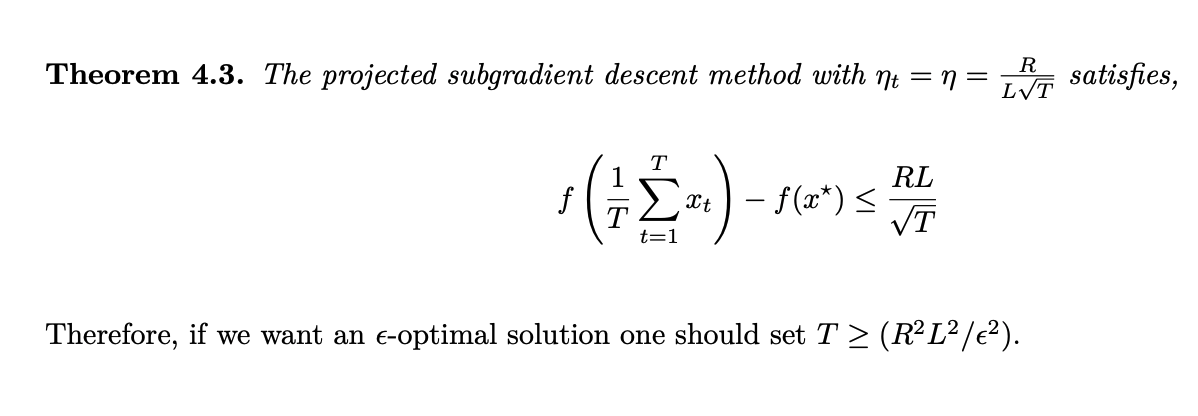



In [10]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(n_feature, n_hidden),
            torch.nn.Linear(n_hidden, n_output)
        ).to(device)

    def forward(self, x):
        return self.features(x)


In [15]:
def train(experiment,optimizer_name, epoch,lr,weight_decay):
  network.train()
  optimizer = torch.optim.SGD(network.parameters(), lr=lr)
  targets=torch.LongTensor([target for feature,target in experiment]).to(device)
  if optimizer_name=='gd':
    predictions=network(experiment.data.to(device).float())
    loss = F.nll_loss(predictions, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

  elif optimizer_name=='constrained_gd':
    predictions=network(experiment.data.to(device).float())
    loss = F.nll_loss(predictions, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      for param in network.parameters():
          param.clamp_(-1, 1)
      
    return loss

  elif optimizer_name=='regularized_gd':
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, weight_decay=weight_decay) 
    predictions=network(experiment.data.to(device).float())
    loss = F.nll_loss(predictions, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

  elif optimizer_name=='sgd':
    for i in range(len(experiment)):
      optimizer.zero_grad()
      data,target=experiment[i]
      data=data.to(device).float()
      target=target.type(torch.LongTensor)
      prediction = network(data)
      loss = F.nll_loss(prediction, target.to(device))
      loss.backward()
      optimizer.step()

    return loss

  else:
    raise NotImplementedError(f"This optimizer:{optimizer} is not impelemtned")
  

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


n_epochs = 15
batch_size_train = 64
momentum = 0.5
log_interval = 1
lrs=[1e-4]
weight_decays=[1e-5]

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)


optimizers_names = ['sgd'] 
experimetns = {
    "zero_to_four_vs_five_to_nine": mnist_trainset_zero_to_four_vs_five_to_nine,
    "even_vs_odd": mnist_trainset_even_vs_odd,
    "prime_vs_not_prime": mnist_trainset_prime_vs_not_prime
}

for experiment in experimetns:
  for optimizer_name in optimizers_names:
    for lr in lrs:
      for weight_decay in weight_decays:
          print(f"experiment:{experiment} | optimizer_name:{optimizer_name}")
          network = Net(n_feature=784, n_hidden=10, n_output=2)
          run=wandb.init(project="Final Project in Advanced Lectures in Learning", entity="sagit", name=f"experiment:{experiment} | optimizer_name:{optimizer_name} | lr:{lr} | weight_decay:{weight_decay}")
          wandb.watch(network, log_freq=1)
          for epoch in range(1, n_epochs + 1):
            loss=train(experimetns[experiment],optimizer_name, epoch,lr, weight_decay)
            if epoch % log_interval==0:
              print(f"loss:{loss}")
              wandb.log({
                  "loss": loss,
                  "epoch": epoch
              })

Using device: cuda
experiment:zero_to_four_vs_five_to_nine | optimizer_name:sgd


loss:-4488642048.0
loss:-5.639435600891006e+19
loss:-7.085488539087675e+29
loss:-inf


KeyboardInterrupt: ignored